# Cifar10 Classification

Until now, we have implemented several pieces of a deep learning pipeline and even trained a two-layer neural network, but all the hyperparameters were already set to some values yielding resonable results. In real-life problems, however, much of the work in a deep learning project will be geared towards finding the best hyperparameters for a certain problem. In this notebook we will explore some good practices for network debugging and hyperparameters search, as well as extending our previously binary classification neural network to a multi-class one.

Let's go!

In [1]:
import os
print(os.getcwd())

from google.colab import drive
drive.mount('/content/drive')

/content
Mounted at /content/drive


In [2]:
os.listdir()
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/HW6/6/exercise_06_cleaned' # Please change to your folder
GOOGLE_DRIVE_PATH = os.path.join('/content','drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
os.chdir(GOOGLE_DRIVE_PATH)

['__init__.py', 'create_submission.sh', 'exercise_code', 'datasets', 'models', 'exercise06.zip', '1.cifar10_classification.ipynb']


In [3]:
# Some lengthy setup.
import matplotlib.pyplot as plt
import numpy as np
import os

from exercise_code.networks.layer import (
    Sigmoid, 
    Relu, 
    LeakyRelu, 
    Tanh,
)
from exercise_code.data import (
    DataLoader,
    ImageFolderDataset,
    RescaleTransform,
    NormalizeTransform,
    FlattenTransform,
    ComposeTransform,
)
from exercise_code.data.image_folder_dataset import RandomHorizontalFlip
from exercise_code.networks import (
    ClassificationNet,
    BCE,
    CrossEntropyFromLogits
)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 1. Quick recap (and some new things)

Until now, in the previous exercises, we focused on building and understanding all the necessary modules for training a simple model. We followed the Pytorch implementations closely, as this is the framework we will use later and we want you to have a smoother transition to its APIs. 

In the figure below you can see the main components in Pytorch. Before starting the actual exercise, we begin with a quick recap of **our implementation** of these components. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Everything is already implemented for this part, but we <b>strongly</b> encourage you to check out the respective source files in order to have a better understanding. </p>
</div>

<img src="https://cdn-images-1.medium.com/max/800/1*uZrS4KjAuSJQIJPgOiaJUg.png" style="width: 500px;">

## 1.1 Dataset and Dataloader

Data preparation represents an important part of deep learning projects. The data comes from different sources and in different formats and is prepared differently from application to application. One part, however, is clear: because entire datasets are usually too large for us to handle at once, we train our models on smaller batches of data. 

The goal of the ```Dataset``` class is to encapsulate all the 'dirty' data processing: loading and cleaning the data, storing features (or names of files where features can be found) and labels, as well as providing the means for accessing individual (transformed) items of the data using the ```__getitem__()``` function and an index. You already implemented an ```ImageFolderDataset``` (in ```exercise_code/data/image_folder_dataset.py```) class in Exercise 3. We we will reuse this class here.

For processing the data, you implemented several transforms in Exercise 3 (```RescaleTransform```, ```NormalizeTransform```, ```ComposeTransform```). In this exercise we are working with images, which are multidimensional arrays, but we are using simple feedforward neural network which takes a one dimensional array as an input, so it is necessary to reshape the images before feeding them into the model. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the reshape operation in the <code>FlattenTransform</code> class, which can be found in <code>../exercise_06/exercise_code/data/image_folder_dataset.py</code>. </p>
</div>

In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/HW6/6/datasets/cifar10.zip" -d "/content/drive/MyDrive/Colab Notebooks/HW6/6/datasets/cifar10/"

In [4]:
#download_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(i2dl_exercises_path, "datasets", "cifar10/cifar10")

# Use the Cifar10 mean and standard deviation computed in Exercise 3.
cifar_mean = np.array([0.49191375, 0.48235852, 0.44673872])
cifar_std  = np.array([0.24706447, 0.24346213, 0.26147554])

# Define all the transforms we will apply on the images when 
# retrieving them.
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)
flatten_transform = FlattenTransform()
compose_transform = ComposeTransform([rescale_transform, 
                                      normalize_transform,
                                      flatten_transform])

# Create a train, validation and test dataset.
datasets = {}
for mode in ['train', 'val', 'test']:
    crt_dataset = ImageFolderDataset(
        mode=mode,
        root=cifar_root, 
        #download_url=download_url,
        transform=compose_transform,
        split={'train': 0.6, 'val': 0.2, 'test': 0.2}
    )
    datasets[mode] = crt_dataset

Then, based on this ```Dataset``` object, we can construct a ```Dataloader``` object which samples a random mini-batch of data at once. 

In [5]:
# Create a dataloader for each split.
dataloaders = {}
for mode in ['train', 'val', 'test']:
    crt_dataloader = DataLoader(
        dataset=datasets[mode],
        batch_size=256,
        shuffle=True,
        drop_last=True,
    )
    dataloaders[mode] = crt_dataloader

Because the ```Dataloader``` has the ```__iter__()``` method, we can simply iterate through the batches it produces, like this:

```python
for batch in dataloader['train']:
    do_something(batch)
```

## 1.2 Data Augmentation

After the above preprocessing steps, our data is in a good shape and ready to be fed into our network. As explained in the chapter above, we used the transformation functions `RescaleTransform`, `NormalizeTransform` and `FlattenTransform` to achieve this shape. These are the general steps that you need to perform on the data before we can even start the training. Of course, all these steps have to be applied to all three splits of our dataset (train, val and test split). So in other words, preprocessing involves preparing the data before they are used in training and inference. 

Besides these basic transformations, there are many other transformation methods that you can apply to the images. For example, you can <b>flip the images horizontally</b> or <b>blur the image</b> and use these new images to enlarge your dataset. This idea is called Data Augmentation and it involves methods that alter the training images to generate a synthetic dataset that is larger than your original dataset and will hopefully improve the performance of your model. The purpose here is different than in the data preprocessing steps and there is one big difference between data augmentation and data preprocessing: The transformation methods to enlarge your dataset should only be applied to the training data. The validation and test data are not affected by these methods.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>The choice of transformation methods to use for data augmentation can be seen as a hyperparameter of your model and you can try to include these to enlarge your training data and obtain better results for your model. In <code>exercise_code/data/image_folder_dataset.py</code> we implemented the function <code>RandomHorizontalFlip</code> for you, which is randomly flipping an image. Check out the implementation.</p>
    <p> Later, we will apply some hyperparameter tuning and in order to improve your model's accuracy, you could try to include some data augmentation methods. Fell free to play around and maybe also implement some other methods as for example Gaussian Blur or Rotation. </p>       
</div>

Let us quickly check out the `RandomHorizontalFlip` method with an image of the Cifar10 dataset in the following cell.

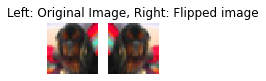

In [ ]:
#Load the data in a dataset without any transformation 
dataset = ImageFolderDataset(
        mode=mode,
        root=cifar_root, 
        #download_url=download_url,
        split={'train': 0.6, 'val': 0.2, 'test': 0.2},
    )

#Retrieve an image from the dataset and flip it
image = dataset[1]['image']
transform = RandomHorizontalFlip(1)
image_flipped = transform(image)

#Show the two images
plt.figure(figsize = (2,2))
plt.subplot(1, 2, 1)
plt.imshow(image.astype('uint8'))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_flipped.astype('uint8'))
plt.axis('off')
plt.title("Left: Original Image, Right: Flipped image")
plt.show()

## 1.3 Layers

Now, that the data is prepared, we can discuss the model in which we are feeding the data. In our case the model will be a neural network. 

In Exercise 5, you implemented a simple 2-layer neural network that had a hidden size as a parameter:

$$ 
{\hat{y}} = \sigma(\sigma({x W_1} + {b_1}) {W_2} + {b_2}) 
$$

where $ \sigma({x}) $ was the sigmoid function, $ {x} $ was the input, $ {W_1}, {W_2} $ the weight matrices and $ {b_1}, {b_2}$ the biases for the two layers.

This is how we used this network:

In [ ]:
input_size = datasets['train'][0]['image'].shape[0]
model = ClassificationNet(input_size=input_size, hidden_size=512)

Note that we updated the ```ClassificationNet``` from the previous exercise, so that now you can customize more: the number of outputs, the choice of activation function, the hidden size etc. We encourage you to check out the implementation in ```exercise_code/networks/classification_net.py``` 

In [ ]:
num_layer = 2
reg = 0.1

model = ClassificationNet(activation=Sigmoid(), 
                          num_layer=num_layer, 
                          reg=reg,
                          num_classes=10)

Then, the forward and backward passes through the model were simply:

```python

# X is a batch of training features 
# X.shape = (batch_size, features_size)
y_out = model.forward(X)

# dout is the gradient of the loss function w.r.t the output of the network.
# dout.shape = (batch_size, )
model.backward(dout)
```

Just as the learning rate or the number of iterations we want to train for, the number of hidden layers and the number of units in each hidden layer are also hyperparameters. In this notebook you will play with networks of different sizes and will see the impact that the network capacity has.

Before we move on to the loss functions, we want to have a look at the activation functions. The choice of an activation function can have a huge impact on the performance of the network that you are designing. So far, you have implemented the `Sigmoid` and the `Relu` activation function in Exercise 5. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Take a look at the <code>Sigmoid</code> and the <code>Relu</code> class in <code>exercise_code/networks/layer.py</code> and the implementation of the respective forward and backward pass. Make sure to understand why we use <b>element-wise product</b> instead of dot product in the backward pass of the <code>Sigmoid</code> class to compute the gradient $dx$. That will be helpful for your later implementation of other activation functions.</p>
    <p> <b>Note:</b> The <code>cache</code> variable is used to store information from the forward pass and then pass this information in the backward pass to make use of it there. The implementation of both classes show that this variable can be used differently - depending on what information is needed in the backward pass. </p>
</div>

Now, we want to have a look at two other, very common activation functions that you have already met in the lecture: Leaky ReLU activation function and Tanh activation function. 

**Leaky Relus** are one attempt to fix the “dying ReLU” problem. Instead of the function being zero when $x<0$, a leaky ReLU has a small negative slope (for example, 0.01). That is, the function computes $f(x) = \mathbb{1}(x < 0) (\alpha x) + \mathbb{1}(x>=0) (x)$ where $\alpha$ is a small constant. Some people report success with this form of activation function, but the results are not always consistent.

The **tanh non-linearity** squashes a real-valued number to the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the tanh non-linearity is always preferred to the sigmoid non-linearity. Also note that the tanh neuron is simply a scaled sigmoid neuron, in particular the following holds: $\tanh(x) = 2 \cdot \sigma(2x) -1$.

<img class=left src=https://pytorch.org/docs/stable/_images/LeakyReLU.png alt="Figure3" width="350" align='left'/> 
<img class=right src=https://pytorch.org/docs/stable/_images/Tanh.png alt="Figure4" width="350"/>

<div class="alert alert-info">
    <h3>Task: Implement Activation Layers</h3>
    <p> Now, it is your turn to implement the <code>LeakyRelu</code> and the <code>Tanh</code> class in <code>exercise_code/networks/layer.py</code> by completing the <code>forward</code> and the <code>backward</code> functions. You can test your implementation in the following two cells. </p>
    <p> <b>Note:</b> Always remember to return a cache in <code>forward</code> for later backpropagation in <code>backward</code>. As we have seen above, the <code>cache</code> variable can be used differently for two activation functions.</p>
</div>

Use this cell to test your implementation of the `LeakyRelu` class:

In [ ]:
from exercise_code.tests.layer_tests import *
print(LeakyReluTestWrapper()())

LeakyReluForwardTest passed.
LeakyReluBackwardTest passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
Score: 100/100
You secured a score of :100


And this cell to test your implementation of the `Tanh` class:

In [ ]:
print(TanhTestWrapper()())

TanhForwardTest passed.
TanhBackwardTest passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
Score: 100/100
You secured a score of :100


Congratulations, you now implemented all four different activation functions! These activation layers are now ready to be used when you start building your own network.

## 1.4 Loss

In order to measure how well a network is performing, we implemented several ```Loss``` classes (```L1```, ```MSE```, ```BCE```, each preferred for a certain type of problems) in ```exercise_code/networks/loss.py```.

Each implemented a ```forward()``` method, which outputs a number that we use as a proxy for our network performance. 

Also, because our goal was to change the weights of the network such that this loss measure decreases, we were also interested in the gradients of the loss w.r.t the outputs of the network, $ \nabla_{\hat{y}} L({\hat{y}}, {y}) $. This was implemented in ```backward()```. 

In previous exercises, we only worked with binary classification and used binary cross entropy (```BCE```) as a loss function.

$$ BCE(\hat{y}, y) = \frac{1}{N} \sum_{i=1}^N \Big [-y_i \log(\hat{y_i}) - (1-y_i) \log(1 - \hat{y_i}) \Big] $$ 

where
- $ N $ was the number of samples we were considering
- $\hat{y}_i$ was the network's prediction for sample $i$. Note that this was a valid probability $\in [0, 1]$, because we applied a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation on the last layer. 
- $ y_i $ was the ground truth label (0 or 1, depending on the class)

Because we have 10 classes in the CIFAR10 dataset, we need a generalization of the binary cross entropy for multiple classes. This is simply called the cross entropy loss and has the following definition:

$$ CE(\hat{y}, y) = \frac{1}{N} \sum_{i=1}^N \sum_{k=1}^{C} \Big[ -y_{ik} \log(\hat{y}_{ik}) \Big] $$

where:
- $ N $ is again the number of samples
- $ C $ is the number of classes
- $ \hat{y}_{ik} $ is the probability that the model assigns for the $k$th class when the $i$th sample is the input. **Because we don't apply any activation function on the last layer of our network, its outputs for each sample will not be a valid probability distribution over the classes. We call these raw outputs of the network '[logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045)' and we will apply a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation in order to obtain a valid probability distribution.** 
- $y_{ik} = 1 $ iff the true label of the $i$th sample is $k$ and 0 otherwise. This is called a [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

You can check for yourself that when the number of classes $ C $ is 2, then the binary cross entropy is actually equivalent to the cross entropy.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the <code>CrossEntropyFromLogits</code> class, which can be found in <code>../exercise_06/exercise_code/networks/loss.py</code>. </p>
</div>

In [ ]:
loss = CrossEntropyFromLogits()

Just as with the previous losses we have seen, we can simply get the results of the forward and backward passes as follows:

```python
# y_out is the output of the neural network
# y_truth is the actual label from the dataset
loss.forward(y_out, y_truth)
loss.backward(y_out, y_truth)
```

## 1.5 Optimizer

Now, knowing the gradient of the loss w.r.t the ouputs of the network, as well as the local gradient for each layer of the network, we can use the chain rule to compute all gradients. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>We implemented several optimizer classes <code>SGD</code>, <code>Adam</code>, <code>sgd_momentum</code> class that implement different first-order parameter update rules, which can be found in <code>../exercise_06/exercise_code/networks/optimizer.py</code>. </p>
    <p>The <code>step()</code> method iterates through all the parameters of a model and updates them using the gradient information.</p>
</div>

What the optimizer is doing, in pseudocode, is the following:

```python
for param in model:
    # Use the gradient to update the weights.
    update(param)
    
    # Reset the gradient after each update.
    param.gradient = 0
```

```SGD``` had the simplest update rule:
```python
def update(param):
    param = param - learning_rate * param.gradient
```

For the more complicated update rules, see ```exercise_code/networks/optimizer.py```

## 1.6 Solver

The ```Solver``` is where all the above elements come together: Given a train and a validation dataloader, a model, a loss and an optimizer, it uses the training data to optimize a model in order to get better predictions. We simply call ```train()``` and it does its 'magic' for us!
```python
solver = Solver(model, 
                dataloaders['train'], 
                dataloaders['val'], 
                learning_rate=0.001, 
                loss_func=MSE(), 
                optimizer=SGD)

solver.train(epochs=epochs)
```

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check out the implementation of <code>train()</code> in <code>../exercise_06/exercise_code/solver.py</code>. </p>
</div>

## 1.7 Weight Regularization

Before we finish this section of recap, we want to take a look at some regularization method that has been introduced in the lecture and that is super helpful to improve robustness of our model. Here, we talk about weight regularization.

Weight regularization has been introduced to you as a method preventing our model from overfitting. Essentially, it is a term (solely depending on the weights of our model) that is added to the final loss and that encodes some preference for a certain set of weights $W$ over others. In the lecture, we compared two weight regularization methods and their respective preference for weight vectors. We made the following observation: 

1. L1 regularization: Enforces sparsity 
2. L2 regularization: Enforces that weights have similar values

The most common weight regularization method is the L2 regularization. From the observations made in the lecture that makes totally sense - at least when we compare it to the L1 regularization. The L2 regularization penalty in the loss prefers smaller and more diffuse weight vectors and hence the model is encouraged to take into account all input dimensions to small amounts rather than a few input dimensions and very strongly.

When using weight regularization, the loss function is a composition of two parts:
$$L = \underbrace{\frac{1}{N} \sum_{i} L_i}_{\text{data loss}}  + \underbrace{\lambda R(W)}_{\text{regularization loss}}$$
The first one being the data loss, which is calculated with the Cross Entropy loss in our model. The second part is called the regularization loss $R(W)$ and is computed in the L2 case as follows:
$$R(W) = \sum_{k} \sum_{l} w_{k,l}^2$$



# 2. An overview of hyperparameters


<img src=https://images.deepai.org/glossary-terms/05c646fe1676490aa0b8cab0732a02b2/hyperparams.png alt=hyperparameter width=700>

A **hyperparameter** is a parameter that is set before the learning process begins. Recall that the parameters of weight matrix and bias vector are learned during the learning process.

The hyperparameters are essential, for they control and affect the whole training and have a great impact on the performance of the model. 

Some examples of hyperparameters we have covered in lectures:
* Network architecture
    * Choice of activation function
    * Number of layers
    * ...
* Learning rate
* Number of epochs
* Batch size
* Regularization strength
* Momentum
* ...

## 2.1 Start debugging your own network!

As already suggested in the lectures, you may always want to start from small and simple architectures, to make sure you are going the right way. 

First you may need to overfit a single training sample, then a few batches of training samples, then go deeper with larger neural networks and the whole training data.

Here we always provide a default neural network (i.e. ClassificationNet) with arbitrary number of layers, which is a generalization from a fixed 2-layer neural network in exercise 5. You are welcome to implement your own network, in that case just implement **MyOwnNetwork** in ```exercise_code/networks/classification_net.py```. You can also copy things from ClassficationNet and make a little adjustment to your own network. For either way, just pick a network and comment out the other one, then run the cells below for debugging.

<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>Please, make sure you don't modify the ClassificationNet itself so that you can always have a working network to fall back on</p>
    <p>In order to pass this submissions, you can <b>first stick to the default ClassificationNet implementation without changing any code at all</b>. The goal of this submission is to find reasonable hyperparameters and the parameter options of the ClassificationNet are broad enough.</p>
    <p>Once you have surpassed the submission goal, you can try to implement additional activation functions in the accompanying notebook, try different weight initializations or other adjustments by writing your own network architecture in the MyOwnNetwork class.</p>
</div>

First, let's begin with a 2-layer neural network, and overfit one single training sample.

After training, let's evaluate the training process by plotting the loss curves.

In [6]:
from exercise_code.solver import Solver
from exercise_code.networks.optimizer import SGD, Adam
from exercise_code.networks import MyOwnNetwork

num_layer = 2 
epochs = 20
reg = 0.1
batch_size = 4

#model = ClassificationNet(num_layer=num_layer, reg=reg)
model = MyOwnNetwork(num_layer=num_layer, reg=reg)

loss = CrossEntropyFromLogits()

# Make a new data loader with a single training image
overfit_dataset = ImageFolderDataset(
    mode='train',
    root=cifar_root, 
    #download_url=download_url,
    transform=compose_transform,
    limit_files=1
)
dataloaders['train_overfit_single_image'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)

# Decrease validation data for only debugging
debugging_validation_dataset = ImageFolderDataset(
    mode='val',
    root=cifar_root, 
    #download_url=download_url,
    transform=compose_transform,
    limit_files=100
)
dataloaders['val_500files'] = DataLoader(
    dataset=debugging_validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

solver = Solver(model, dataloaders['train_overfit_single_image'], dataloaders['val_500files'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 20) train loss: 2.312450; val loss: 2.312476
(Epoch 2 / 20) train loss: 2.312450; val loss: 2.308473
(Epoch 3 / 20) train loss: 2.287930; val loss: 2.310920
(Epoch 4 / 20) train loss: 2.246560; val loss: 2.318073
(Epoch 5 / 20) train loss: 2.179783; val loss: 2.329463
(Epoch 6 / 20) train loss: 2.081800; val loss: 2.345483
(Epoch 7 / 20) train loss: 1.949993; val loss: 2.366869
(Epoch 8 / 20) train loss: 1.783791; val loss: 2.394783
(Epoch 9 / 20) train loss: 1.580184; val loss: 2.430602
(Epoch 10 / 20) train loss: 1.347554; val loss: 2.475925
(Epoch 11 / 20) train loss: 1.098878; val loss: 2.532367
(Epoch 12 / 20) train loss: 0.859469; val loss: 2.601150
(Epoch 13 / 20) train loss: 0.662865; val loss: 2.681485
(Epoch 14 / 20) train loss: 0.537881; val loss: 2.769085
(Epoch 15 / 20) train loss: 0.484988; val loss: 2.857006
(Epoch 16 / 20) train loss: 0.478422; val loss: 2.938032
(Epoch 17 / 20) train loss: 0.489401; val loss: 3.006560
(Epoch 18 / 20) train loss: 0.500258; va

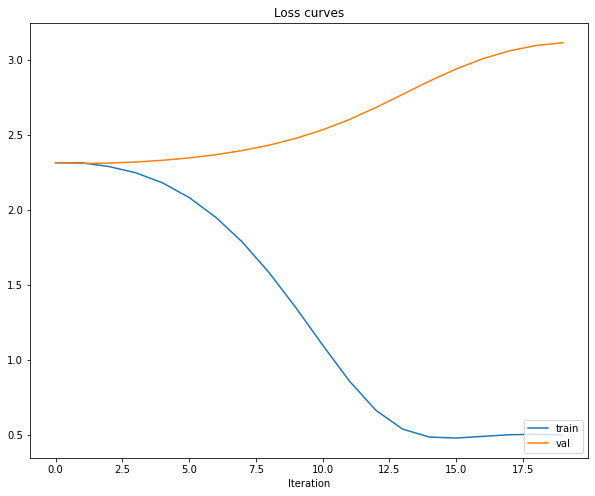

In [7]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [8]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_single_image'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))

Training accuray: 1.00000
Validation accuray: 0.07000


This time let's try to overfit to a small set of training batch samples. Please observe the difference from above. 

In [9]:
from exercise_code.networks import MyOwnNetwork

num_layer = 2
epochs = 100
reg = 0.1
num_samples = 10

#model = ClassificationNet(num_layer=num_layer, reg=reg)
model = MyOwnNetwork(num_layer=num_layer, reg=reg)

loss = CrossEntropyFromLogits()

# Make a new data loader with a our num_samples training image
overfit_dataset = ImageFolderDataset(
    mode='train',
    root=cifar_root, 
    #download_url=download_url,
    transform=compose_transform,
    limit_files=num_samples
)
dataloaders['train_overfit_10samples'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)

solver = Solver(model, dataloaders['train_overfit_10samples'], dataloaders['val_500files'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 100) train loss: 2.312498; val loss: 2.312483
(Epoch 2 / 100) train loss: 2.311074; val loss: 2.307076
(Epoch 3 / 100) train loss: 2.281947; val loss: 2.314271
(Epoch 4 / 100) train loss: 2.180660; val loss: 2.341822
(Epoch 5 / 100) train loss: 2.002433; val loss: 2.420455
(Epoch 6 / 100) train loss: 1.894747; val loss: 2.552186
(Epoch 7 / 100) train loss: 1.816430; val loss: 2.636881
(Epoch 8 / 100) train loss: 1.622625; val loss: 2.654874
(Epoch 9 / 100) train loss: 1.622977; val loss: 2.636282
(Epoch 10 / 100) train loss: 1.523390; val loss: 2.598657
(Epoch 11 / 100) train loss: 1.388599; val loss: 2.588987
(Epoch 12 / 100) train loss: 1.476192; val loss: 2.606498
(Epoch 13 / 100) train loss: 1.272716; val loss: 2.647594
(Epoch 14 / 100) train loss: 1.359902; val loss: 2.685228
(Epoch 15 / 100) train loss: 1.200264; val loss: 2.704055
(Epoch 16 / 100) train loss: 1.104084; val loss: 2.729584
(Epoch 17 / 100) train loss: 1.081804; val loss: 2.741716
(Epoch 18 / 100) train 

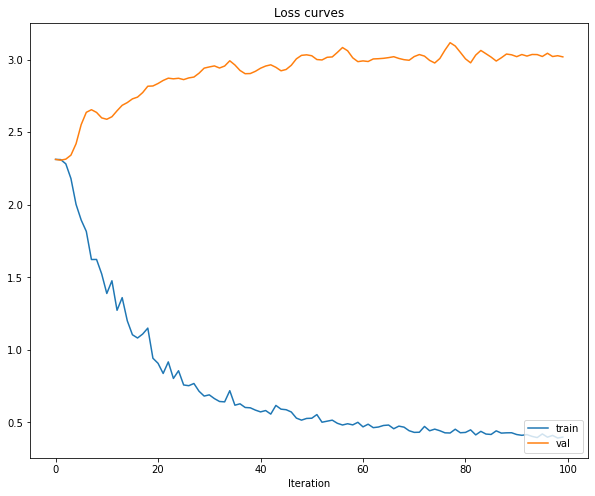

In [10]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [11]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_10samples'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))

Training accuray: 1.00000
Validation accuray: 0.17000


If you're overfitting the training data, that means the network's implementation is correct. However, as you have more samples to overfit, your accuracy will be way lower. You can increase the number of epochs above to achieve better results.

Now let's try to feed all the training and validation data into the network, but this time we set the same hyperparameters for 2-layer and 5-layer networks, and compare the different behaviors.

<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>This may take about 1 min for each epoch as the training set is quite large. For convenience, we only train on 1000 images for now but use the full validation set.</p>
</div>

In [12]:
from exercise_code.networks import MyOwnNetwork

num_layer = 2
epochs = 5
reg = 0.01

# Make a new data loader with 1000 training samples
num_samples = 1000
overfit_dataset = ImageFolderDataset(
    mode='train',
    root=cifar_root, 
    #download_url=download_url,
    transform=compose_transform,
    limit_files=num_samples
)
dataloaders['train_small'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)


# Change here if you want to use the full training set
use_full_training_set = False
if not use_full_training_set:
    train_loader = dataloaders['train_small']
else:
    train_loader = dataloaders['train']
    

#model = ClassificationNet(num_layer=num_layer, reg=reg)
model = MyOwnNetwork(num_layer=num_layer, reg=reg)

loss = CrossEntropyFromLogits()

solver = Solver(model, train_loader, dataloaders['val'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam) 

solver.train(epochs=epochs)

(Epoch 1 / 5) train loss: 2.303581; val loss: 2.303576
(Epoch 2 / 5) train loss: 2.207876; val loss: 2.119802
(Epoch 3 / 5) train loss: 2.069308; val loss: 2.109291
(Epoch 4 / 5) train loss: 2.016786; val loss: 2.114609
(Epoch 5 / 5) train loss: 1.965113; val loss: 2.207367


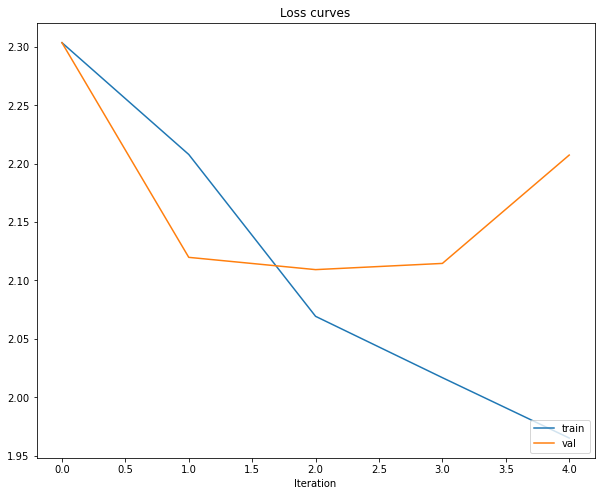

In [13]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [14]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(train_loader)))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val'])))

Training accuray: 0.45400
Validation accuray: 0.30717


In [15]:
from exercise_code.networks import MyOwnNetwork

num_layer = 5
epochs = 5
reg = 0.01

#model = ClassificationNet(num_layer=num_layer, reg=reg)
model = MyOwnNetwork(num_layer=num_layer, reg=reg)

# Change here if you want to use the full training set
use_full_training_set = False
if not use_full_training_set:
    train_loader = dataloaders['train_small']
else:
    train_loader = dataloaders['train']

loss = CrossEntropyFromLogits()

solver = Solver(model, train_loader, dataloaders['val'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam) #1e-3

solver.train(epochs=epochs)

(Epoch 1 / 5) train loss: 2.310889; val loss: 2.310889
(Epoch 2 / 5) train loss: 2.302457; val loss: 2.302395
(Epoch 3 / 5) train loss: 2.300688; val loss: 2.302413
(Epoch 4 / 5) train loss: 2.299492; val loss: 2.302757
(Epoch 5 / 5) train loss: 2.298745; val loss: 2.303132


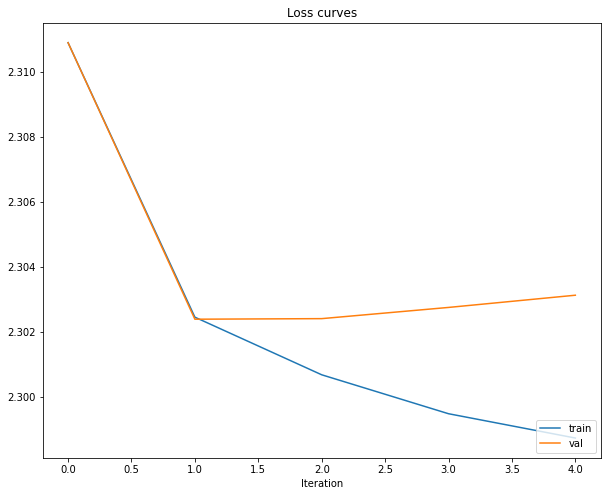

In [16]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [17]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(train_loader)))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val'])))

Training accuray: 0.12300
Validation accuray: 0.10073


As you can see from above, the same hyperparameter set can decrease the loss for a 2-layer network, but for 5-layer network, it hardly works.

The steps above are already mentioned in the lectures as debugging steps before training a neural network. 

If you implement your own network, make sure you do the steps above before tuning the hyperparameters as below. 

## 2.2 Difficulty in tuning hyperparameters
As can be seen through the results of training a larger network, training with whole data doesn't fit the training data as well as training with small number of training data. Besides, the architecture of neural network makes a difference, too. Small decisions on hyperparameters count. 

Usually, but not always, hyperparameters cannot be learned using well known gradient based methods (such as gradient descent), which are commonly employed to learn parameters. Besides, some hyperparameters can affect the structure of the model and the loss function.

As mentioned before, hyperparameters need to be set before training. Tuning hyperparameters is hard, because you always have to try different combinations of the hyperparameters, train the network, do the validation and pick the best one. Besides, it is not guaranteed that you'll find the best combination.

Next you will do hands on learning with hyperparameter tuning methods that are covered in lectures.

# 3. Hyperparameter Tuning

![alt text](https://blog.floydhub.com/content/images/2018/08/Screen-Shot-2018-08-22-at-17.59.25.png "")

One of the main challenges in deep learning is finding the set of hyperparameters that performs best.

So far, we have followed a manual approach by guessing hyperparameters, running the model, observing the result and maybe tweaking the hyperparameters based on this result. As you have probably noticed, this manual hyperparameter tuning is unstructured, inefficient and can become very tedious.


A more systematic (and actually very simple) approach for hyperparameter tuning that you've already learned in the lecture  is implementing a **Grid Search**. 



## 3.1 Grid Search
Grid search is a simple and naive, yet effective method to automate the hyperparameter tuning:

* First, you define the set of parameters you want to tune, e.g. $\{learning\_rate, regularization\_strength\}$.

* For each hyperparameter, you then define a set of possible values, e.g. $learning\_rate = \{0.0001, 0.001, 0.01, 0.1\}$.

* Then, you train a model for every possible combination of these hyperparameter values and afterwards select the combination that works best (e.g. in terms of accuracy on your validation set).

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Check out our <code>grid_search</code> implementation in <code>../exercise_6/exercise_code/hyperparameter_tuning.py</code>. We show a simple for loop implementation and a more sophisticated one for multiple inputs. </p>
</div>
 
 <div class="alert alert-warning">
    <h3>Note:</h3>
    <p>To keep things simple for the beginning, it'll be enough to just focus on the hyperparameters <code>learning_rate</code> and <code>regularization_strength</code> here, as in the example above.</p>
</div>

In [18]:
from exercise_code.networks import MyOwnNetwork

# Specify the used network
model_class = MyOwnNetwork

from exercise_code import hyperparameter_tuning
best_model, results = hyperparameter_tuning.grid_search(
    dataloaders['train_small'], dataloaders['val_500files'],
    grid_search_spaces = {
        "learning_rate": [1e-2, 1e-3, 1e-4], 
        "reg": [1e-4]
    },
    model_class=model_class,
    epochs=10, patience=5)


Evaluating Config #1 [of 3]:
 {'learning_rate': 0.01, 'reg': 0.0001}
(Epoch 1 / 10) train loss: 2.302580; val loss: 2.302529
(Epoch 2 / 10) train loss: 6.417744; val loss: 5.192581
(Epoch 3 / 10) train loss: 5.236957; val loss: 6.026522
(Epoch 4 / 10) train loss: 6.575856; val loss: 8.314375
(Epoch 5 / 10) train loss: 6.324594; val loss: 6.325861
(Epoch 6 / 10) train loss: 6.584858; val loss: 8.246289
Stopping early at epoch 5!

Evaluating Config #2 [of 3]:
 {'learning_rate': 0.001, 'reg': 0.0001}
(Epoch 1 / 10) train loss: 2.302590; val loss: 2.302599
(Epoch 2 / 10) train loss: 2.075151; val loss: 2.054805
(Epoch 3 / 10) train loss: 1.813206; val loss: 2.032152
(Epoch 4 / 10) train loss: 1.617524; val loss: 1.996405
(Epoch 5 / 10) train loss: 1.437366; val loss: 2.195941
(Epoch 6 / 10) train loss: 1.231395; val loss: 2.377254
(Epoch 7 / 10) train loss: 1.111641; val loss: 2.287633
(Epoch 8 / 10) train loss: 0.957990; val loss: 2.496580
(Epoch 9 / 10) train loss: 0.820109; val loss: 2

From the results of your grid search, you might already have found some hyperparameter combinations that work better than others. A common practice is to now repeat the grid search on a more narrow domain centered around the parameters that worked best. 

**Conclusion Grid Search**

With grid search we now have automated the hyperparameter tuning to a certain degree. Another advantage is, that since the training of all models are independent of each other, you can parallelize the grid search, i.e.,  try out different hyperparameter configurations in parallel on different machines.

However, as you have probably noticed, there is one big problem with this approach: the number of possible combinations to try out grows exponentially with the number of hyperparameters ("curse of dimensionality"). As we add more hyperparameters to the grid search, the search space will explode in time complexity, making this strategy unfeasible.

Especially when your search space contains more than 3 or 4 dimensions, it is often better to use another, similar hyperparameter tuning method that you've already learned about: random search.

## 3.2 Random Search
Random search is very similar to grid search, with the only difference, that instead of providing specific values for every hyperparameter, you only define a range for each hyperparameter - then, the values are sampled randomly from the provided ranges.

![alt text](https://i.stack.imgur.com/cIDuR.png "")

The figure above illustrates the difference in the hyperparameter space exploration between grid search and random search: assume you have 2 hyperparameters with each 3 values. Running a grid search results in training $3^2=9$ different models - but in the end, you've just tired out 3 values for each parameter. For random search on the other hand, after training 9 models you'll have tried out 9 different values for each hyperparameter, which often leads much faster to good results.

To get a deeper understanding of random search and why it is more efficient than grid search, you should definitely check out this paper: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Check out our <code>random_search</code> implementation in <code>../exercise_6/exercise_code/hyperparameter_tuning.py</code></p>
</div>


*Hint: regarding the sample space of each parameter, think about the scale for which it makes most sense to sample in. For example the learning rate is usually sampled on a logarithmic scale!*

*For simplicity and speed, just use the `train_batches`-dataloader!*

In [19]:
from exercise_code.hyperparameter_tuning import random_search
from exercise_code.networks import MyOwnNetwork

# Specify the used network
model_class = MyOwnNetwork

best_model, results = random_search(
    dataloaders['train_small'], dataloaders['val_500files'],
    random_search_spaces = {
        "learning_rate": ([1e-2, 1e-7], 'log'),
        "reg": ([1e-3, 1e-7], "log"),
        "loss_func": ([CrossEntropyFromLogits()], "item")
    },
    model_class=model_class,
    num_search = 1, epochs=20, patience=5)


Evaluating Config #1 [of 1]:
 {'learning_rate': 8.679696338548068e-05, 'reg': 4.233925954105153e-07, 'loss_func': <exercise_code.networks.loss.CrossEntropyFromLogits object at 0x7f453c773d90>}
(Epoch 1 / 20) train loss: 2.302558; val loss: 2.302572
(Epoch 2 / 20) train loss: 2.242035; val loss: 2.153349
(Epoch 3 / 20) train loss: 2.072940; val loss: 2.061400
(Epoch 4 / 20) train loss: 1.969381; val loss: 2.013185
(Epoch 5 / 20) train loss: 1.891939; val loss: 1.986921
(Epoch 6 / 20) train loss: 1.833281; val loss: 1.977168
(Epoch 7 / 20) train loss: 1.789540; val loss: 1.959652
(Epoch 8 / 20) train loss: 1.745786; val loss: 1.945989
(Epoch 9 / 20) train loss: 1.709658; val loss: 1.946997
(Epoch 10 / 20) train loss: 1.674633; val loss: 1.939647
(Epoch 11 / 20) train loss: 1.641500; val loss: 1.934242
(Epoch 12 / 20) train loss: 1.609440; val loss: 1.929164
(Epoch 13 / 20) train loss: 1.574661; val loss: 1.940700
(Epoch 14 / 20) train loss: 1.543683; val loss: 1.926048
(Epoch 15 / 20) t

It's time to run it with the whole dataset, and let it search for a few hours for a nice configuration. 

However, to save some time, let's first implement an **early-stopping** mechanism, that you also already know from the lecture.

## 3.3 Early Stopping

By now you've already seen a lot of training curves:

<img src=http://fouryears.eu/wp-content/uploads/2017/12/early_stopping.png></img>

Usually, at some point the validation loss goes up again, which is a sign that we're overfitting to our training data. Since it actually doesn't make any sense to train further at this point, it's common practice to apply "early stopping", i.e., cancel the training process when the validation loss doesn't improve anymore. The nice thing about this concept is, that not only it improves generalization through the prevention of overfitting, but also it saves us a lot of time - one of our most valuable resources in deep learning.

Since there are natural fluctuations in the validation loss, you usually don't cancel the training process right at the first epoch when the validation-loss increases, but instead, you wait for some epochs (specified by the `patience`-parameter) and if the loss still doesn't improve, we stop.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the early stopping mechanism in <code>../exercise_6/exercise_code/solver.py</code>.
 </p>
</div>

## 3.4 Let's find the perfect model!

You've now set everything up to start training your model and finding a nice set of hyper parameters using a combination of grid or random search!

Since we'll now be training with a much larger number of samples, you should be aware that this process will definitely take some time! So be prepared to let your machine run for a while. 

At the beginning, it's a good approach to first do a coarse random search across a wide range of values to find promising sub-ranges of your parameter space. Afterwards, you can zoom in to these ranges and do another random search (or grid search) to finetune the configuration.

You don't have to use the whole dataset at the beginning, instead you can also use a medium large subset of the samples. Also, you don't need to train for a large number of epochs - as mentioned above: we first want to get an overview about our hyper parameters.

<div class="alert alert-info">
    <h3>Task: Hyperparameters Tunning & Model Training </h3>
        <p> Now, it is your turn to do the hyperparamater tuning. In the cell below, you can use the <code>random_search</code> function to find a good choice of parameters. Put in some reasonable ranges for the hyperparameters and evaluate them.
    <p> <b>Note:</b> At the beginning, it's a good approach to first do a coarse random search across a <b> wide range of values</b> to find promising sub-ranges of your parameter space and use <b> a medium large subset of the dataset </b>instead the whole as well. Afterwards, you can zoom in to these ranges and do another random search (or grid search) to finetune the configuration. Use the cell below to play around and find good hyperparameters for your model!</p>
        <p> Finally, once you've found some promising hyperparameters (or narrowed them down to promising subranges), it's time to utilize these hyperparameters to train your network on the whole dataset for a large number of epochs so that your own model can reach an acceptable performance. 
        <p> <b>Hint:</b> You may use a <code>Solver</code> class we provided before or directly use the <code>random_search</code> function (as you can also monitor the loss here) for model training.
</div>

In [41]:
from exercise_code.networks import MyOwnNetwork
from exercise_code.hyperparameter_tuning import random_search

########################################################################
# TODO:                                                                #
# Implement your own neural network and find suitable hyperparameters  #
# Be sure to edit the MyOwnNetwork class in the following code snippet #
# to upload the correct model!                                         #
########################################################################

model_class = MyOwnNetwork

best_model, results = random_search(
    dataloaders['train_small'], dataloaders['val_500files'],
    random_search_spaces = {
        "learning_rate": ([1e-1, 1e-6], 'log'),
        "reg": ([1e-2, 1e-7], "log"),
        "loss_func": ([CrossEntropyFromLogits()], "item")
    },
    model_class=model_class,
    num_search = 5, epochs=30, patience=5)
########################################################################
#                           END OF YOUR CODE                           #
########################################################################


Evaluating Config #1 [of 5]:
 {'learning_rate': 0.0012068832965321517, 'reg': 0.000500267312842098, 'loss_func': <exercise_code.networks.loss.CrossEntropyFromLogits object at 0x7f453c79c250>}
(Epoch 1 / 30) train loss: 2.302634; val loss: 2.302611
(Epoch 2 / 30) train loss: 2.124405; val loss: 2.069540
(Epoch 3 / 30) train loss: 1.875503; val loss: 2.123178
(Epoch 4 / 30) train loss: 1.702332; val loss: 2.052806
(Epoch 5 / 30) train loss: 1.506966; val loss: 2.201354
(Epoch 6 / 30) train loss: 1.379968; val loss: 2.449946
(Epoch 7 / 30) train loss: 1.193068; val loss: 2.381726
(Epoch 8 / 30) train loss: 1.095027; val loss: 2.730852
(Epoch 9 / 30) train loss: 0.971184; val loss: 2.774105
Stopping early at epoch 8!

Evaluating Config #2 [of 5]:
 {'learning_rate': 0.007977653492998248, 'reg': 7.751801324808636e-06, 'loss_func': <exercise_code.networks.loss.CrossEntropyFromLogits object at 0x7f453c79c250>}
(Epoch 1 / 30) train loss: 2.302586; val loss: 2.302596
(Epoch 2 / 30) train loss: 

Now it's time to edit the ranges above and adjust them to explore regions that performed well!

Also, feel free to experiment around! Also the network architecture, optimizer options and activations functions, etc. are hyperparameters that you can change!

Try to get your accuracy as high as possible! That's all what counts for this submission!

You'll pass if you reach at least **48%** accuracy on our test set - but there will also be a leaderboard of all students of this course. Will you make it to the top?

## 3.5 Checking the validation accuracy

In [39]:
labels, pred, acc = best_model.get_dataset_prediction(dataloaders['train'])
print("Train Accuracy: {}%".format(acc*100))
labels, pred, acc = best_model.get_dataset_prediction(dataloaders['val'])
print("Validation Accuracy: {}%".format(acc*100))

Train Accuracy: 34.04625618811881%
Validation Accuracy: 33.66477272727273%


# 4. Test your model
When you have finished your hyperparameter tuning and are sure you have your final model that performs well on the validation set (**you should at least get 48% accuracy on the validation set!**), it's time to run your  model on the test set.

<div class="alert alert-danger">
    <h3>Important</h3>
    <p>As you have learned in the lecture, you must only use the test set one single time! So only run the next cell if you are really sure your model works well enough and that you want to submit. Your test set is different from the test set on our server, so results may vary. Nevertheless, you will have a reasonable close approximation about your performance if you only do a final evaluation on the test set.</p>
    <p>If you are an external student that can't use our submission webpage: this test performance is your final result and if you surpassed the threshold, you have completed this exercise :). Now, train again to aim for a better number!</p>
</div>

In [40]:
# comment this part out to see your model's performance on the test set.
labels, pred, acc = best_model.get_dataset_prediction(dataloaders['test'])
print("Test Accuracy: {}%".format(acc*100))


Test Accuracy: 32.57575757575758%


<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>The "real" test set is actually the dataset we're using for testing your model, which is <b>different</b> from the test-set you're using here.</p>
</div>

# 5. Saving your Model

In [ ]:
from exercise_code.tests import save_pickle
save_pickle({"cifar_fcn": best_model}, "cifar_fcn.p")

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('exercise06')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1.cifar10_classification.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1.cifar10_classification.ipynb
Zipping successful! Zip is stored under: /content/drive/MyDrive/Colab Notebooks/HW6/6/exercise_06_cleaned/exercise06.zip
